In [21]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import re
import json
import seaborn as sns
from collections import Counter
from attributes_prompts import dialogue_acts, dialogue_acts_decode, motive_decode
from matplotlib.gridspec import GridSpec

In [22]:
DATA_FOLDER = "./data/insq/agg/"
RAW_TRAIN_DATA = "./data/insq/train_data/"
RAW_DEV_DATA = "./data/insq/dev_data/"
RAW_TEST_DATA = "./data/insq/test_data/"
FIG_FOLDER = "./figure/"

In [23]:
def load_json_data(path):
    with open(path) as f:
        json_objs = json.load(f)
        return json_objs

def get_episode_meta(episode):
    meta_json_path = episode.replace(".xlsx", "_meta.json")
    meta = None
    with open(meta_json_path) as f:
        metas = json.load(f)
        if len(metas.values()) > 0:
            meta = list(metas.values())[0]
        meta["topic"] = " ".join(meta["topic"].split("_")[2:])
    return meta

def generate_intervals(n, m):
    interval_size = n // m
    intervals = []
    for i in range(m):
        start = i * interval_size
        end = (i + 1) * interval_size - 1
        if i == m - 1:  # Adjust the last interval to include the remainder
            end = n - 1
        intervals.append((start, end))
    return intervals

def find_intercepted_interval_indexes(range_tuple, intervals):
    i, j = range_tuple
    intercepted_indexes = []

    for index, interval in enumerate(intervals):
        start, end = interval
        # Check if intervals intersect
        if start <= j and end >= i:
            intercepted_indexes.append(index)

    return intercepted_indexes

def generate_utterance_label(label_sequence, meta, prior_mod_info=None, post_mod_info=None):
    unique_labels = set([str(l["labels"]["da"]) for l in label_sequence])
    motives = set([c for l in label_sequence for c in l["labels"]["m"]])
    unique_pos = set([j for i in label_sequence for j in i["interval_index"]])
    utterance_label = "-".join(sorted(unique_labels))
    motives_label = "".join(sorted(motives))
    utterance_pos = sorted(unique_pos)
    target_speakers = sorted(set([str(l["labels"]["ts"]) for l in label_sequence]))
    utt_length = sum([l["count"] for l in label_sequence])

    speakers_option = meta["speakers"]
    prior_speaker = None
    post_speaker = None
    if prior_mod_info:
        prior_speaker = prior_mod_info["speaker"]
        prior_speaker = [s for s in speakers_option if prior_speaker in s]
        if prior_speaker:
            prior_speaker = prior_speaker[0]
    if post_mod_info:
        post_speaker = post_mod_info["speaker"]
        post_speaker = [s for s in speakers_option if post_speaker in s]
        if post_speaker:
            post_speaker = post_speaker[0]


    for i, s in enumerate(label_sequence):

        target_speaker = meta["speakers"][int(s["labels"]["ts"])]

        responding = False
        responded = False

        if "team" in target_speaker:
            team = "for" if "Support" in target_speaker else "against"
            if prior_speaker:
                responding = team in prior_speaker
            if post_speaker:
                responded = team in post_speaker
        else:
            if prior_speaker:
                responding = prior_speaker == target_speaker
            if post_speaker:
                responded = post_speaker == target_speaker

        specific = not any([w in target_speaker.lower() for w in ["everyone", "self", "unknown", "audience", "team", "speakers", "all"]])
        
        label_sequence[i]["specific"] = specific
        label_sequence[i]["responding"] = responding
        label_sequence[i]["responded"] = responded

    if prior_mod_info:
        respond_prior = any([prior_mod_info["speaker"] in s for s in target_speakers])
    else:
        respond_prior = False

    if post_mod_info:
        respond_post = any([post_mod_info["speaker"] in s for s in target_speakers])
    else:
        respond_post = False

    if post_mod_info and respond_prior:
        position_rotate = (prior_mod_info["role"] != post_mod_info["role"]) and (prior_mod_info["role"] != "audience" and post_mod_info["role"] != "audience")
    else:
        position_rotate = False

    return {"split": label_sequence[0]["split"], "episode": label_sequence[0]["episode"], "speaker": label_sequence[0]["speaker"], "count": utt_length, "role": label_sequence[0]["role"], "interval_index": utterance_pos, "sentence_count": len(label_sequence),
            "labels":{"da": utterance_label, "ts": target_speakers, "m": motives_label,
                      "respond_prior": respond_prior, "respond_post": respond_post, "position_rotate": position_rotate}}, label_sequence

In [24]:
def get_label_sequences(corpus, mode="human"):

    agg_dict = {}
    data_source = glob.glob(f"./data/{corpus}/agg/" + "/*.json")
    for d in data_source:
        data = {l["id"]: l for l in load_json_data(d)}
        key = d.split("/")[-1].replace(".json", "")
        agg_dict[key] = data

    stats = {"overall": {}}
    episodes = {}
    for k in agg_dict.keys():
        if k == "train" and mode != "human":
            episodes[k] = glob.glob(f"./data/{corpus}/train_data/" + "/*.xlsx")
            stats[k] = {}
        elif k == "dev":
            episodes[k] = glob.glob(f"./data/{corpus}/dev_data/" + "/*.xlsx")
            stats[k] = {}
        elif k == "test":
            episodes[k] = glob.glob(f"./data/{corpus}/test_data/" + "/*.xlsx")
            stats[k] = {}

    inter_utterance_sequence = []
    intra_utterance_sequence = []

    utterance_stats = []
    eps_speaker_stats = []
    mod_sents = []


    for split, v in episodes.items():
        for episode in v:
            episode_inter_utterance_sequence = []
            debate = pd.read_excel(episode, index_col=0)
            meta = get_episode_meta(episode)
            total_tokens_count = np.sum([len(str(s).split(" ")) for s in debate["text"].dropna().tolist()])
            token_count_intervals = generate_intervals(total_tokens_count, 40)
            utterance_cache = []
            prior_mod_cache = {
                "speaker": "",
                "role": "",
                "index": -1
            }
            accumulate_tokens_count = 0
            eps_speaker_stats.append({"split": split, "episode": episode.split("/")[-1].replace(".xlsx", ""), "speaker_count": len(meta["speakers"]) - 7, "token_count": total_tokens_count})

            for i, r in debate.iterrows():
                if pd.isna(r.text):
                    continue
                text = str(r.text)
                tokens_count = len(text.split(" "))
                interval_index = find_intercepted_interval_indexes((accumulate_tokens_count, accumulate_tokens_count+tokens_count), token_count_intervals)
                accumulate_tokens_count += tokens_count
                if r.role == "mod":
                    id = episode.split("/")[-1].replace(".xlsx", "") + "_" + r.id
                    if split == "train":
                        answer = agg_dict[split][id]["answer"]
                        label = str(dialogue_acts[answer["dialogue act"]])
                        target_speaker = answer['target speaker(s)']
                        target_speaker = int(target_speaker.split(" ")[0])
                    else:
                        answer = agg_dict[split][id]["answer"]["gpt"]
                        label = str(answer["dialogue act"])
                        target_speaker = answer['target speaker(s)']
                        target_speaker = int(target_speaker)

                        ##get votes
                        human_da = agg_dict[split][id]["answer"]["human"]["dialogue act"]["label"]
                        human_ts = agg_dict[split][id]["answer"]["human"]["target speaker(s)"]["label"]
                        human_im = agg_dict[split][id]["answer"]["human"]["motives"]["informational motive"]["label"]
                        human_cm = agg_dict[split][id]["answer"]["human"]["motives"]["coordinative motive"]["label"]
                        human_sm = agg_dict[split][id]["answer"]["human"]["motives"]["social motive"]["label"]

                        da_votes = list(agg_dict[split][id]["answer"]["human"]["dialogue act"]["vote"].values())
                        ts_votes = list(agg_dict[split][id]["answer"]["human"]["target speaker(s)"]["vote"].values())
                        im_votes = list(agg_dict[split][id]["answer"]["human"]["motives"]["informational motive"]["vote"].values())
                        cm_votes = list(agg_dict[split][id]["answer"]["human"]["motives"]["coordinative motive"]["vote"].values())
                        sm_votes = list(agg_dict[split][id]["answer"]["human"]["motives"]["social motive"]["vote"].values())

                        if mode == "human":
                            answer = agg_dict[split][id]["answer"]["human"]
                            label = str(answer["dialogue act"]["label"])
                            target_speaker = answer["target speaker(s)"]["label"]
                            target_speaker = int(target_speaker)
                            motive_code = "".join([m[0] for m, v in answer["motives"].items() if v["label"] == 1])
                        else:
                            answer = agg_dict[split][id]["answer"]["gpt"]
                            label = str(answer["dialogue act"])
                            target_speaker = answer['target speaker(s)']
                            target_speaker = int(target_speaker)
                            motive_code = "".join([m[0] for m in answer["motives"]])

                    mod_sents.append({"text": text,
                                      "prob": label == "0",
                                      "conf": label == "1",
                                      "inst": label == "2",
                                      "inte": label == "3",
                                      "supp": label == "4",
                                      "util": label == "5",
                                      "im": "i" in motive_code,
                                      "cm": "c" in motive_code,
                                      "sm": "s" in motive_code })
                    utterance_cache.append({"split": split, "episode": episode.split("/")[-1].replace(".xlsx", ""), "speaker": r.speaker, "role": r.role, "interval_index": interval_index, "count": tokens_count, "labels":{"da":str(label), "m": motive_code, "ts": target_speaker}})
                else:
                    speaker = r.speaker
                    label = "transition"
                    if r.role == prior_mod_cache["role"]:
                        if speaker == prior_mod_cache["speaker"]:
                            if i - prior_mod_cache["index"] == 1:
                                interval_index.extend(episode_inter_utterance_sequence[-1]["interval_index"])
                                interval_index = set(interval_index)
                                episode_inter_utterance_sequence[-1]["interval_index"] = sorted(interval_index)
                                episode_inter_utterance_sequence[-1]["sentence_count"] += len(text.split(". "))
                                episode_inter_utterance_sequence[-1]["count"] += tokens_count
                                prior_mod_cache['index'] = i
                                continue
                            label = "speaker cont."
                        elif corpus == "insq":
                            label = "stance cont."

                    cur_utt_info = {"split": split, "episode": episode.split("/")[-1].replace(".xlsx", ""), "speaker": r.speaker, "sentence_count": len(text.split(". ")),
                                    "role": r.role, "interval_index": interval_index, "count": tokens_count, "labels":{"transition": label}}

                    if utterance_cache:
                        agg_mod_utt, utterance_cache = generate_utterance_label(utterance_cache, meta, prior_mod_cache, cur_utt_info)
                        episode_inter_utterance_sequence.append(agg_mod_utt)
                        utterance_stats.append(agg_mod_utt)
                        intra_utterance_sequence.append(utterance_cache)
                        utterance_cache = []

                    prior_mod_cache["speaker"] = speaker
                    prior_mod_cache["role"] = r.role
                    prior_mod_cache["index"] = i
                    episode_inter_utterance_sequence.append(cur_utt_info)
                    utterance_stats.append(cur_utt_info)

            if utterance_cache:
                agg_mod_utt, utterance_cache = generate_utterance_label(utterance_cache, meta, prior_mod_cache, cur_utt_info)
                episode_inter_utterance_sequence.append(agg_mod_utt)
                utterance_stats.append(agg_mod_utt)
                intra_utterance_sequence.append(utterance_cache)
                utterance_cache = []
            inter_utterance_sequence.append(episode_inter_utterance_sequence)

    for i in range(len(inter_utterance_sequence)):
        inter_utterance_sequence[i] = [{"speaker": None, "role": None, "interval_index": [0], 'individual target speaker count':0, "labels":{"transition": "#START"}}] + inter_utterance_sequence[
            i] + [{"speaker": None, "role": None, "interval_index": [40-1], 'individual target speaker count':0,  "labels":{"transition": "#END"}}]

    for i in range(len(intra_utterance_sequence)):
        intra_utterance_sequence[i] = [{"speaker": None, "role": None, "interval_index": [0], "labels":{"transition": "#START"}}] + intra_utterance_sequence[
            i] + [{"speaker": None, "role": None, "interval_index": [intra_utterance_sequence[i][-1]["interval_index"][-1]], "labels":{"transition": "#END"}}]

    # eps_df = pd.DataFrame(eps_speaker_stats)
    # eps_df.to_csv(f"{corpus}_eps_stats.csv")
    #
    # utt_df = pd.DataFrame(utterance_stats).drop(["speaker", "interval_index", "labels"], axis=1)
    # utt_df.to_csv(f"{corpus}_utt_stats.csv")

    return inter_utterance_sequence, intra_utterance_sequence

In [25]:
def get_transition_matrix(sequences, filter_funcs=[], pair_filter_funcs=[], show=False, name = None):
    transitions = {}
    unique_states = set()
    meta_transitions = {}
    meta_unique_states = set()
    for states in sequences:
        if filter_funcs:
            states = [s for s in states if all([f(s) for f in filter_funcs])]
        for (s1, s2) in zip(states[:-1], states[1:]):
            if s1["role"] == "host" or s2["role"] == "host":
                continue
            if pair_filter_funcs:
                if not all([f((s1, s2)) for f in pair_filter_funcs]):
                    continue
            if "da" in s1["labels"]:
                s1 = s1["labels"]["da"].split("-")
                meta_s1 = "moderation"
            else:
                s1 = [s1["labels"]["transition"]]
                meta_s1 = s1[0]

            if "da" in s2["labels"]:
                s2 = s2["labels"]["da"].split("-")
                meta_s2 = "moderation"
            else:
                s2 = [s2["labels"]["transition"]]
                meta_s2 = s2[0]

            for i in list(set(s1)):
                if i in dialogue_acts_decode:
                    i = dialogue_acts_decode[i]
                if i not in transitions:
                    unique_states.add(i)
                    transitions[i] = {}
                for j in list(set(s2)):
                    if j in dialogue_acts_decode:
                        j = dialogue_acts_decode[j]
                    if j not in transitions[i]:
                        unique_states.add(j)
                        transitions[i][j] = 0
                    transitions[i][j] += 1
            
            if meta_s1 not in meta_transitions:
                meta_unique_states.add(meta_s1)
                meta_transitions[meta_s1] = {}
            
            if meta_s2 not in meta_transitions[meta_s1]:
                meta_unique_states.add(meta_s2)
                meta_transitions[meta_s1][meta_s2] = 0
            
            meta_transitions[meta_s1][meta_s2] += 1
                    
    unique_states = sorted(unique_states)
    meta_unique_states = sorted(meta_unique_states)

    # Initialize the transition matrix with zeros
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    # Fill the transition matrix with transition counts
    for s1 in transitions:
        for s2 in transitions[s1]:
            transition_matrix.at[s1, s2] = transitions[s1][s2]
            
    # Initialize the transition matrix with zeros
    meta_transition_matrix = pd.DataFrame(0, index=meta_unique_states, columns=meta_unique_states)

    # Fill the transition matrix with transition counts
    for s1 in meta_transitions:
        for s2 in meta_transitions[s1]:
            meta_transition_matrix.at[s1, s2] = meta_transitions[s1][s2]

#     # Step 2: Calculate Probabilities
#     transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

#     if show:
#     # Step 3: Plot the Transition Matrix
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(transition_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=True)
#         plt.title(name)
#         plt.xlabel("To State")
#         plt.ylabel("From State")
#         if name:
#             plt.savefig(FIG_FOLDER + name, format='pdf', dpi=300, bbox_inches = "tight")
#         plt.show()
    return transition_matrix, meta_transition_matrix

In [26]:
def get_motive_transition_matrix(sequences, filter_funcs=[], pair_filter_funcs=[], show=False, name = None):
    transitions = {}
    unique_states = set()
    for states in sequences:
        if filter_funcs:
            states = [s for s in states if all([f(s) for f in filter_funcs])]
        for (s1, s2) in zip(states[:-1], states[1:]):
            if s1["role"] == "host" or s2["role"] == "host":
                continue
            if pair_filter_funcs:
                if not all([f((s1, s2)) for f in pair_filter_funcs]):
                    continue
            if "m" in s1["labels"]:
                s1 = s1["labels"]["m"]
            else:
                s1 = [s1["labels"]["transition"]]

            if "m" in s2["labels"]:
                s2 = s2["labels"]["m"]
            else:
                s2 = [s2["labels"]["transition"]]

            for i in s1:
                if i in motive_decode:
                    i = motive_decode[i]
                if i not in transitions:
                    unique_states.add(i)
                    transitions[i] = {}
                for j in s2:
                    if j in motive_decode:
                        j = motive_decode[j]
                    if j not in transitions[i]:
                        unique_states.add(j)
                        transitions[i][j] = 0
                    transitions[i][j] += 1
                    
    unique_states = sorted(unique_states)

    # Initialize the transition matrix with zeros
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    # Fill the transition matrix with transition counts
    for s1 in transitions:
        for s2 in transitions[s1]:
            transition_matrix.at[s1, s2] = transitions[s1][s2]

    # Step 2: Calculate Probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    if show:
    # Step 3: Plot the Transition Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(transition_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=True)
        plt.title(name)
        plt.xlabel("To State")
        plt.ylabel("From State")
        if name:
            plt.savefig(FIG_FOLDER + name, format='pdf', dpi=300, bbox_inches = "tight")
        plt.show()
    return transition_matrix

In [27]:
def get_motive_dialogue_act_matrix(label_sequence):
    items = []
    labels_count = {"da":[0, 0, 0, 0, 0, 0], "m":[0, 0, 0], "total": 0}
    for sents in label_sequence:
        for sent in sents:
            if "transition" in sent["labels"]:
                continue
            labels_count["total"] += 1
            dialogue_act, motives = sent["labels"]["da"], sent["labels"]["m"]
            labels_count["da"][int(dialogue_act)] += 1
            if motives:
                for m in motives:
                    index = "ics".index(m)
                    labels_count["m"][index] += 1
                    items.append((dialogue_acts_decode[dialogue_act], motive_decode[m]))

    # Step 1: Identify Unique Items
    first_dim = [item[0] for item in items]
    second_dim = [item[1] for item in items]
    unique_first_dim = sorted(set(first_dim))
    unique_second_dim = sorted(set(second_dim))

    # Step 2: Count Co-occurrences
    co_occurrence_counts = pd.DataFrame(0, index=unique_first_dim, columns=unique_second_dim)

    for item in items:
        co_occurrence_counts.at[item[0], item[1]] += 1


    co_occurrence_counts = co_occurrence_counts[[motive_decode['i'], motive_decode['c'], motive_decode['s']]]
    co_occurrence_counts.columns = ["IM", "CM", "SM"]
    co_occurrence_counts = co_occurrence_counts.T
    co_occurrence_counts = co_occurrence_counts.div(labels_count['m'], axis=0)
    
    co_occurrence_counts = co_occurrence_counts.round(4)
    # co_occurrence_counts["total"] = [c / labels_count['total'] for c in labels_count['da']]
    co_occurrence_counts["total"] = labels_count['m']
    
    last_row = pd.DataFrame([labels_count['da'] + [labels_count['total']]], columns = co_occurrence_counts.columns)
    last_row.index = ["total"]
    co_occurrence_counts = pd.concat([co_occurrence_counts, last_row])
    co_occurrence_counts.columns = [re.sub('[^A-Za-z]+', '', c)[:4] if c != "total" else "total" for c in co_occurrence_counts.columns]
    
    # total_row = co_occurrence_counts.sum(axis=0)
    # total_row = total_row.to_frame().T
    # total_row.index = ['Total']
    # co_occurrence_counts = pd.concat([co_occurrence_counts, total_row])
    
    return co_occurrence_counts, labels_count

In [28]:
# state filters
mod_filter = lambda x: x["role"] == "mod"

def position_filter_factor(positions_range):
    def position_filter(state):
        position_index = state["interval_index"]
        start, end = positions_range
        # Check if intervals intersect
        for i in position_index:
            if start <= i <= end:
                return True
        return False
    return position_filter


# pair filters
def motive_filter_factor(motives):
    def motive_filer(pair):
        for p in pair:
            if "m" in p["labels"]:
                if any([m in motives for m in p["labels"]["m"]]):
                    return True
        return False
    return motive_filer

In [29]:
def get_meta_sequence(eps):
    meta_seq = []
    for utt_seq in eps:
        new_utt_seq = []
        for u in utt_seq:
            labels = u["labels"]
            if "transition" in labels:
                trans = labels['transition']
                if trans == '#START' or trans == "#END":
                    continue
                else:
                    if trans == "stance cont.":
                        trans = "transition"
                    new_utt_seq.append(trans)
            else:
                new_utt_seq.append("moderation")
        meta_seq.append(new_utt_seq)
        
    return meta_seq

In [30]:
def get_meta_transition_matrix(sequences):
    transitions = {}
    unique_states = set()
    for states in sequences:
        for (s1, s2) in zip(states[:-1], states[1:]):
            if s1 not in transitions:
                unique_states.add(s1)
                transitions[s1] = {}
            
            if s2 not in transitions[s1]:
                unique_states.add(s2)
                transitions[s1][s2] = 0
            
            transitions[s1][s2] += 1
                    
    unique_states = sorted(unique_states)

    # Initialize the transition matrix with zeros
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    # Fill the transition matrix with transition counts
    for s1 in transitions:
        for s2 in transitions[s1]:
            transition_matrix.at[s1, s2] = transitions[s1][s2]

    # Step 2: Calculate Probabilities
    # transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # if show:
    # # Step 3: Plot the Transition Matrix
    #     plt.figure(figsize=(8, 6))
    #     sns.heatmap(transition_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=True)
    #     plt.title(name)
    #     plt.xlabel("To State")
    #     plt.ylabel("From State")
    #     if name:
    #         plt.savefig(FIG_FOLDER + name, format='pdf', dpi=300, bbox_inches = "tight")
    #     plt.show()
    return transition_matrix

## Get data

In [32]:
insq_inter_utterance_sequence, insq_intra_utterance_sequence = get_label_sequences("insq")

In [10]:
rdt_inter_utterance_sequence, rdt_intra_utterance_sequence = get_label_sequences("roundtable")

In [70]:
test_seq = get_meta_sequence(rdt_inter_utterance_sequence)

In [109]:
insq_mat, meta_trans = get_transition_matrix(insq_inter_utterance_sequence)

In [105]:
trans_mat

,#END,#START,0.probing,1.confronting,2.instruction,3.interpretation,4.supplement,5.utility,speaker cont.,transition
#END,0,0,2,0,23,3,66,28,1,11
#START,0,0,0,0,0,0,0,0,0,0
0.probing,0,45,0,0,0,0,0,0,302,747
1.confronting,0,1,0,0,0,0,0,0,45,68
2.instruction,0,28,0,0,0,0,0,0,137,335
3.interpretation,0,1,0,0,0,0,0,0,27,78
4.supplement,0,87,0,0,0,0,0,0,206,574
5.utility,0,85,0,0,0,0,0,0,132,344
speaker cont.,0,0,304,15,129,40,213,185,0,0
transition,0,0,788,99,348,63,588,348,124,841


In [107]:
meta_trans

,#END,#START,moderation,speaker cont.,transition
#END,0,0,76,1,11
#START,0,0,0,0,0
moderation,0,88,0,481,1259
speaker cont.,0,0,606,0,0
transition,0,0,1146,124,841


In [ ]:
# trans_mat = get_transition_matrix([insq_inter_utterance_sequence[0]])
after_mod_db = trans_mat.iloc[8:, 2:]
# after_mod_db.index = [i.split(".")[-1][:4] for i in after_mod_db.index.tolist()]
# after_mod_db.columns = ["spk cont.", "stn cont.", "rotation"]
# after_mod = after_mod.style.background_gradient(cmap='viridis')
after_mod_db.div([7173, 1002, 8376], axis=0)

,0.probing,1.confronting,2.instruction,3.interpretation,4.supplement,5.utility,speaker cont.,stance cont.,transition
speaker cont.,0.194758,0.066081,0.207166,0.040569,0.033598,0.103443,0.003067,0.000418,0.005576
stance cont.,0.190619,0.098802,0.180639,0.033932,0.038922,0.054890,0.109780,0.227545,0.257485
transition,0.155802,0.108047,0.195439,0.034981,0.053486,0.106256,0.087751,0.026146,0.504298


In [108]:
# trans_mat = get_transition_matrix([insq_inter_utterance_sequence[0]])
after_mod_db = trans_mat.iloc[8:, 2:]
# after_mod_db.index = [i.split(".")[-1][:4] for i in after_mod_db.index.tolist()]
# after_mod_db.columns = ["spk cont.", "stn cont.", "rotation"]
# after_mod = after_mod.style.background_gradient(cmap='viridis')
after_mod_db.div([605, 2100], axis=0)

,0.probing,1.confronting,2.instruction,3.interpretation,4.supplement,5.utility,speaker cont.,transition
speaker cont.,0.502479,0.024793,0.213223,0.066116,0.352066,0.305785,0.000000,0.000000
transition,0.375238,0.047143,0.165714,0.030000,0.280000,0.165714,0.059048,0.400476


In [247]:
proact_insq = pd.DataFrame([{"da": s["labels"]["da"], "m": s["labels"]["m"], "responding":s['responding'], "responded": s['responded'], "specific": s['specific']} for u in insq_intra_utterance_sequence for s in u if s["speaker"]])
proact_rdt = pd.DataFrame([{"da": s["labels"]["da"], "m": s["labels"]["m"], "responding":s['responding'], "responded": s['responded'], "specific": s['specific']} for u in rdt_intra_utterance_sequence for s in u if s["speaker"]])

In [254]:
proact_insq[["responding", "responded", "specific"]].mean()

responding    0.257849
responded     0.427880
specific      0.489015
dtype: float64

In [255]:
proact_rdt[["responding", "responded", "specific"]].mean()

responding    0.209976
responded     0.502743
specific      0.562564
dtype: float64

In [11]:
def plot_confusion_matrix(cm, labels):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [12]:
def show_practive_metric(df):

    # Create a confusion matrix using crosstab
    confusion_matrix = pd.crosstab(df['responding'], df['responded'], df['specific'], normalize='all')

    # Rename index and columns to reflect the True/False combinations
    confusion_matrix.index = ['not responding', 'responding']
    confusion_matrix.columns = ['not responded', "responded"]

    # Display the confusion matrix as percentages
    confusion_matrix *= 100

    print(confusion_matrix)

In [244]:
confusion_matrix

,not responded,responded
not responding,45.097703,33.904697
responding,4.628043,16.369558


In [241]:
show_practive_metric(proact_insq)

                not responded  responded
not responding      52.212953  22.002165
responding           4.999045  20.785837


In [193]:
show_practive_metric(rdt_insq)

                not responded  responded
not responding      45.097703  33.904697
responding           4.628043  16.369558


In [ ]:
# Example DataFrame
data = {
    'Name': ['Intelligent squared debate', 'Australia parliament', 'Couple counsiling', 'Public company negotiation', 'Panel Discussion'],
    'Probing': [0.8, 0.6, 0.7, 0.9, 0.5],
    'Confronting': [0.4, 0.8, 0.5, 0.6, 0.7],
    'Interpretation': [0.6, 0.7, 0.8, 0.4, 0.9],
    'Instruction': [0.7, 0.5, 0.9, 0.8, 0.6],
    'Utility': [0.5, 0.6, 0.4, 0.7, 0.8]
}

df = pd.DataFrame(data)

# Number of variables we're plotting
categories = list(df.columns[1:])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw y-labels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)

# Plot data
for i in range(len(df)):
    values = df.loc[i].drop('Name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df['Name'][i])
    ax.fill(angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Save the plot as a PDF file
# plt.savefig('spider_plot.pdf', format='pdf')

# Show the plot
plt.show()

## Motives vs. dialogue act distribution

### debate

In [33]:
insq_freq, total_counts = get_motive_dialogue_act_matrix(insq_intra_utterance_sequence)


ValueError: invalid literal for int() with base 10: '1.0'

In [157]:
insq_freq

,prob,conf,inst,inte,supp,util,total
IM,0.4119,0.2300,0.0397,0.1221,0.1903,0.0060,6378
CM,0.1474,0.0997,0.5355,0.0207,0.0861,0.1106,10236
SM,0.0760,0.0151,0.0969,0.0232,0.1381,0.6508,1724
total,3606.0000,1864.0000,5497.0000,832.0000,1745.0000,2159.0000,15703


In [168]:
insq_freq["total"] / 15703

IM       0.406164
CM       0.651850
SM       0.109788
total    1.000000
Name: total, dtype: float64

In [158]:
insq_freq.to_csv("insq_coocur.csv")

### Radio Panel Discussion

In [165]:
rdt_freq, total_counts = get_motive_dialogue_act_matrix(rdt_intra_utterance_sequence)
# styled_df = rdt_freq.style.background_gradient(cmap='viridis')
rdt_freq

,prob,conf,inst,inte,supp,util,total
IM,0.4142,0.0286,0.0132,0.0274,0.5118,0.0048,4160
CM,0.0574,0.0175,0.4251,0.0067,0.3252,0.1680,1482
SM,0.0561,0.0064,0.0222,0.0127,0.2828,0.6197,944
total,1750.0000,124.0000,633.0000,121.0000,2400.0000,806.0000,5834


In [166]:
rdt_freq.to_csv("roundtable_coocur.csv")

In [216]:
total_counts

{'da': [1750, 124, 633, 121, 2400, 806],
 'm': {'i': 4160, 's': 944, 'c': 1482},
 'total': 5834}

In [169]:
rdt_freq["total"] / 5834

IM       0.713061
CM       0.254028
SM       0.161810
total    1.000000
Name: total, dtype: float64

# Inter-uttetrans_matrance moderation participation transition analysis: How do moderator facilitate transition?

In [56]:
trans_mat

,#END,#START,0.probing,1.confronting,2.instruction,3.interpretation,4.supplement,5.utility,speaker cont.,transition
#END,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#START,0.000000,0.0,0.182186,0.004049,0.113360,0.004049,0.352227,0.344130,0.000000,0.000000
0.probing,0.001828,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277879,0.720293
1.confronting,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131579,0.868421
2.instruction,0.046000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.258000,0.696000
3.interpretation,0.028302,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377358,0.594340
4.supplement,0.076125,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.245675,0.678201
5.utility,0.049911,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329768,0.620321
speaker cont.,0.001027,0.0,0.310062,0.046201,0.140657,0.027721,0.211499,0.135524,0.000000,0.127310
transition,0.003669,0.0,0.249166,0.022682,0.111741,0.026017,0.191461,0.114743,0.000000,0.280520


## After moderation

### Debate

In [125]:
trans_mat, meta_mat = get_transition_matrix(insq_inter_utterance_sequence)
after_mod_db = trans_mat.iloc[2:8, 8:]
after_mod_db.index = [i.split(".")[-1][:4] for i in after_mod_db.index.tolist()]
after_mod_db.columns = ["continuation", "stn cont.", "rotation"]
# after_mod = after_mod.style.background_gradient(cmap='viridis')
after_mod_db

,continuation,stn cont.,rotation
prob,1397,191,1305
conf,474,99,905
inst,1486,181,1637
inte,291,34,293
supp,241,39,448
util,742,55,890


In [126]:
after_mod_db['rotation'] = after_mod_db['rotation'] + after_mod_db['stn cont.']

In [127]:
after_mod_db = after_mod_db.drop('stn cont.', axis=1)

In [128]:
after_mod_db = after_mod_db.div(after_mod_db.sum(axis=1), axis=0)

In [129]:
after_mod_db

,continuation,rotation
prob,0.482890,0.517110
conf,0.320704,0.679296
inst,0.449758,0.550242
inte,0.470874,0.529126
supp,0.331044,0.668956
util,0.439834,0.560166


### Panel Discussion

In [130]:
trans_mat, meta_pd = get_transition_matrix(rdt_inter_utterance_sequence)
after_mod_pd = trans_mat.iloc[2:8, 8:]
after_mod_pd.index = [i.split(".")[-1][:4] for i in after_mod_pd.index.tolist()]
after_mod_pd.columns = ["continuation", "rotation"]
# after_mod = after_mod.style.background_gradient(cmap='viridis')
after_mod_pd

,continuation,rotation
prob,304,788
conf,15,99
inst,129,348
inte,40,63
supp,213,588
util,185,348


In [131]:
after_mod_pd = after_mod_pd.div(after_mod_pd.sum(axis=1), axis=0)

In [132]:
after_mod_pd

,continuation,rotation
prob,0.278388,0.721612
conf,0.131579,0.868421
inst,0.270440,0.729560
inte,0.388350,0.611650
supp,0.265918,0.734082
util,0.347092,0.652908


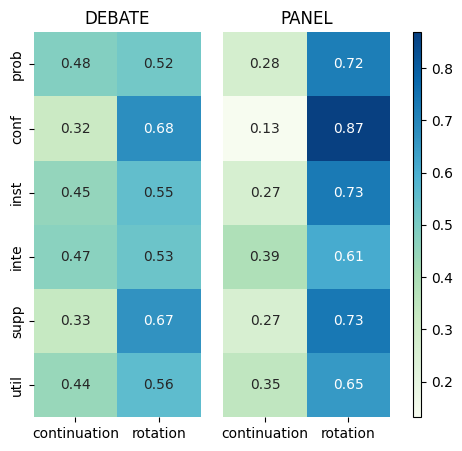

In [133]:
df = after_mod_db
df2 = after_mod_pd

vmin = min(df.values.min(), df2.values.min())
vmax = max(df.values.max(), df2.values.max())

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[2,2,0.1]), figsize=(5, 5))

sns.heatmap(df, annot=True, cbar=False, ax=axs[0], vmin=vmin, vmax=vmax, cmap="GnBu")
sns.heatmap(df2, annot=True, yticklabels=False, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax, cmap="GnBu")

# Add titles to the heatmaps
axs[0].set_title('DEBATE')
axs[1].set_title('PANEL')


fig.colorbar(axs[1].collections[0], cax=axs[2])
# Save the plot as a PDF file
plt.savefig('after_moderation.pdf', format='pdf')
plt.show()

## After participation

### Debate

In [22]:
trans_mat = get_transition_matrix(insq_inter_utterance_sequence)
after_mod_db = trans_mat.iloc[-3:, [2,3,4,5,6,7,9, 10]]
# after_mod_db = after_mod_db.style.background_gradient(cmap="GnBu")

after_mod_db.columns = ["prob", "conf", "inst", "inte", "supp", "util", "stance cont.", "rotation"]
after_mod_db.index = ["spk cont.", "stance cont.", "rotation"]
after_mod_db

,prob,conf,inst,inte,supp,util,stance cont.,rotation
spk cont.,0.214452,0.112553,0.246997,0.053274,0.054630,0.145680,0.02131,0.142387
stance cont.,0.174576,0.077119,0.223729,0.020339,0.038983,0.077966,0.19322,0.185593
rotation,0.153007,0.074210,0.170948,0.025790,0.032008,0.077676,0.02630,0.430581


In [23]:
after_mod_db['rotation'] = after_mod_db['rotation'] + after_mod_db['stance cont.']

In [24]:
after_mod_db = after_mod_db.drop('stance cont.', axis=1)

In [25]:
after_mod_db = after_mod_db.drop('stance cont.', axis=0)

In [26]:
after_mod_db

,prob,conf,inst,inte,supp,util,rotation
spk cont.,0.214452,0.112553,0.246997,0.053274,0.054630,0.145680,0.163696
rotation,0.153007,0.074210,0.170948,0.025790,0.032008,0.077676,0.456881


### Panel discussion

In [27]:
trans_mat = get_transition_matrix(rdt_inter_utterance_sequence)
after_mod_rp = trans_mat.iloc[-2:, [2,3,4,5,6,7,9]]
after_mod_rp.columns = ["prob", "conf", "inst", "inte", "supp", "util", "rotation"]
after_mod_rp.index = ["spk cont.", "rotation"]
# after_mod_rp = after_mod_rp.style.background_gradient(cmap="GnBu")
after_mod_rp

,prob,conf,inst,inte,supp,util,rotation
spk cont.,0.310062,0.046201,0.140657,0.027721,0.211499,0.135524,0.12731
rotation,0.249166,0.022682,0.111741,0.026017,0.191461,0.114743,0.28052


In [28]:
after_mod_pd

,spk cont.,rotation
prob,0.277879,0.720293
conf,0.131579,0.868421
inst,0.258000,0.696000
inte,0.377358,0.594340
supp,0.245675,0.678201
util,0.329768,0.620321


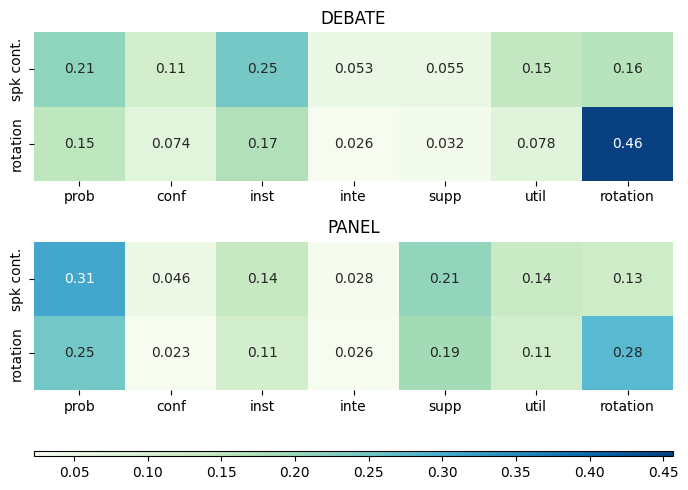

In [30]:
# Assuming after_mod_db and after_mod_pd are already defined DataFrames
df = after_mod_db
df2 = after_mod_rp

vmin = min(df.values.min(), df2.values.min())
vmax = max(df.values.max(), df2.values.max())

# Define the overall figure size
fig = plt.figure(figsize=(7, 5))

# Create a GridSpec with a specific layout
gs = GridSpec(3, 1, height_ratios=[3, 3, 0.1])

# Add subplots for the heatmaps
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax_cbar = fig.add_subplot(gs[2, :])

# First heatmap spans both columns
sns.heatmap(df, annot=True, cbar=False, ax=ax1, vmin=vmin, vmax=vmax, cmap="GnBu")

# Second heatmap only spans the first column (2/3 width)
sns.heatmap(df2, annot=True, cbar=False, ax=ax2, vmin=vmin, vmax=vmax, cmap="GnBu")

# Add titles to the heatmaps
ax1.set_title('DEBATE')
ax2.set_title('PANEL')

# Add a shared colorbar at the bottom
fig.colorbar(ax2.collections[0], cax=ax_cbar, orientation='horizontal')

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('after_speech.pdf', format='pdf')

# Display the plot
plt.show()

# Motives transition

## Inter-utternace

### Debate

In [81]:
trans_mat = get_motive_transition_matrix(insq_inter_utterance_sequence, filter_funcs=[mod_filter])
trans_mat  = trans_mat.style.background_gradient(cmap='viridis')
trans_mat

,coordinative,informational,social
coordinative,0.567691,0.316517,0.115792
informational,0.492831,0.411299,0.095870
social,0.509080,0.315173,0.175747


### Panel Discussion

In [83]:
trans_mat = get_motive_transition_matrix(rdt_inter_utterance_sequence, filter_funcs=[mod_filter])
trans_mat  = trans_mat.style.background_gradient(cmap='viridis')
trans_mat

,coordinative,informational,social
coordinative,0.317502,0.508355,0.174142
informational,0.256804,0.564572,0.178624
social,0.278281,0.500000,0.221719


## Intra-utternace

In [86]:
trans_mat = get_motive_transition_matrix(insq_intra_utterance_sequence, filter_funcs=[mod_filter])
trans_mat  = trans_mat.style.background_gradient(cmap='viridis')
trans_mat

,coordinative,informational,social
coordinative,0.638837,0.263915,0.097248
informational,0.318353,0.637208,0.044439
social,0.518519,0.208535,0.272947


In [87]:
trans_mat = get_motive_transition_matrix(rdt_intra_utterance_sequence, filter_funcs=[mod_filter])
trans_mat  = trans_mat.style.background_gradient(cmap='viridis')
trans_mat

,coordinative,informational,social
coordinative,0.326705,0.487926,0.185369
informational,0.115094,0.795912,0.088994
social,0.242165,0.443020,0.314815


# Intra-utterance moderation analysis: How do moderator acheive the motives?

In [67]:
motives = [None, ["i"], ["s"], ["c"]]

## Debate

In [ ]:
for m_ in motives:
    funcs = []
    pair_funcs = []
    name = "insq_intra_utt"
    if m_:
        m_filer = motive_filter_factor(m_)
        pair_funcs.append(m_filer)
        name += f"_{m_[0]}"
    name += ".pdf"
    get_transition_matrix(insq_intra_utterance_sequence, filter_funcs=funcs, pair_filter_funcs=pair_funcs, show=True, name=name)

In [77]:
db_intra = get_transition_matrix(insq_intra_utterance_sequence)
db_intra = db_intra.iloc[1:, [0,2,3,4,5,6,7]]
db_intra.columns = ["#END", "prob", "conf", "inst", "inte", "supp", "util"]
db_intra.index = ["#START", "prob", "conf", "inst", "inte", "supp", "util"]

In [82]:
rp_intra = get_transition_matrix(rdt_intra_utterance_sequence)
rp_intra = rp_intra.iloc[1:, [0,2,3,4,5,6,7]]
rp_intra.columns = ["#END", "prob", "conf", "inst", "inte", "supp", "util"]
rp_intra.index = ["#START", "prob", "conf", "inst", "inte", "supp", "util"]

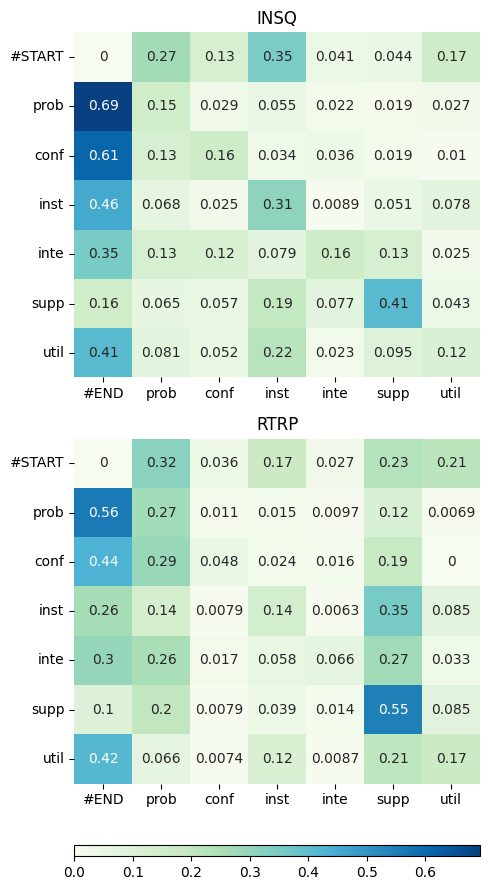

In [107]:

# Assuming after_mod_db and after_mod_pd are already defined DataFrames
df = db_intra
df2 = rp_intra

vmin = min(df.values.min(), df2.values.min())
vmax = max(df.values.max(), df2.values.max())

# Increase the figure size
fig, axs = plt.subplots(nrows=3, ncols=1, gridspec_kw={'height_ratios': [3, 3, 0.1]}, figsize=(5, 9))

# Change the colormap using the 'cmap' parameter
sns.heatmap(df, annot=True, cbar=False, ax=axs[0], vmin=vmin, vmax=vmax, cmap="GnBu")
sns.heatmap(df2, annot=True, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax, cmap="GnBu")

# Add titles to the heatmaps with increased font size
axs[0].set_title('INSQ', fontsize=12)
axs[1].set_title('RTRP', fontsize=12)

# Add a shared colorbar
fig.colorbar(axs[1].collections[0], cax=axs[2], orientation='horizontal')

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('intra_comparison.pdf', format='pdf')

# Display the plot
plt.show()

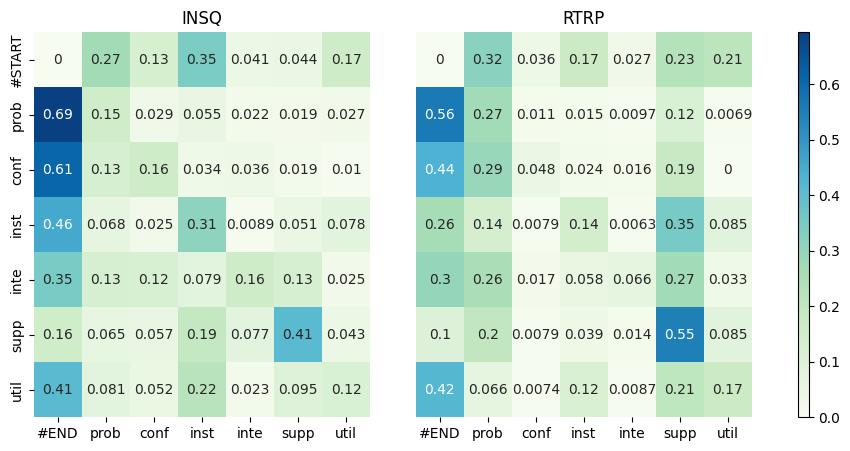

In [103]:
# Assuming after_mod_db and after_mod_pd are already defined DataFrames
df = db_intra
df2 = rp_intra

vmin = min(df.values.min(), df2.values.min())
vmax = max(df.values.max(), df2.values.max())

fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[3,3,0.1]), figsize=(10, 5))

sns.heatmap(df, annot=True, cbar=False, ax=axs[0], vmin=vmin, vmax=vmax, cmap="GnBu")
sns.heatmap(df2, annot=True, yticklabels=False, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax, cmap="GnBu")

# Add titles to the heatmaps
axs[0].set_title('INSQ')
axs[1].set_title('RTRP')


fig.colorbar(axs[1].collections[0], cax=axs[2])
# Save the plot as a PDF file
plt.savefig('intra_comparison.pdf', format='pdf')
plt.show()

### Discussion Panel

In [ ]:
for m_ in motives:
    funcs = []
    pair_funcs = []
    name = "rdt_intra_utt"
    # if m_:
    #     m_filer = motive_filter_factor(m_)
    #     pair_funcs.append(m_filer)
    #     name += f"_{m_[0]}"
    name += ".pdf"
    get_transition_matrix(rdt_intra_utterance_sequence, filter_funcs=[mod_filter], pair_filter_funcs=pair_funcs, show=True, name=name)

In [304]:
insq_eps_stats =  pd.read_csv("roundtable_eps_stats.csv", index_col = 0)
insq_utt_stats =  pd.read_csv("roundtable_utt_stats.csv", index_col = 0)

In [305]:
insq_eps_stats.columns

Index(['split', 'episode', 'speaker_count', 'token_count'], dtype='object')

In [306]:
insq_eps_stats.groupby("split")["speaker_count"].agg(["min", "mean", "max"]).reset_index()

,split,min,mean,max
0,test,0,1.450000,3
1,train,1,2.470588,5


In [105]:
insq_utt_stats.columns

Index(['split', 'episode', 'count', 'role', 'sentence_count'], dtype='object')

In [130]:
mod_utt = insq_utt_stats[insq_utt_stats.role == "mod"]

In [107]:
spks = insq_eps_stats.groupby("split")["speaker_count"].agg(["mean", "std"]).reset_index()

In [131]:
mod_result = mod_utt[mod_utt.split == "test"].groupby("episode")["sentence_count"].agg(['sum', "mean", "count"]).reset_index()
overall_result = insq_utt_stats[insq_utt_stats.split == "test"].groupby("episode")["sentence_count"].agg(['sum', "mean", "count"]).reset_index()

In [115]:
mod_result[["sum", "mean", "count"]].mean()

sum      63.838235
mean      3.262322
count    20.691176
dtype: float64

In [116]:
mod_result[["sum", "mean", "count"]].std()

sum      14.983185
mean      0.798127
count     7.322542
dtype: float64

In [112]:
sums = mod_result['sum'] / overall_result["sum"]
sums.mean()

0.3376698155258596

In [113]:
counts = mod_result['count'] / overall_result["count"]
counts.mean()

0.4018640143009387

In [134]:
sum(mod_utt[mod_utt.split == "train"].sentence_count)

11153

In [20]:
result = insq_eps_stats.groupby('split')['token_count'].agg(['mean', 'std', "count"]).reset_index()

In [21]:
result

,split,mean,std,count
0,dev,8329.363636,1668.317852,11
1,test,7685.263158,1932.887444,19
2,train,8010.333333,1792.803454,78


In [24]:
insq_utt_stats.columns

Index(['split', 'episode', 'count', 'role'], dtype='object')

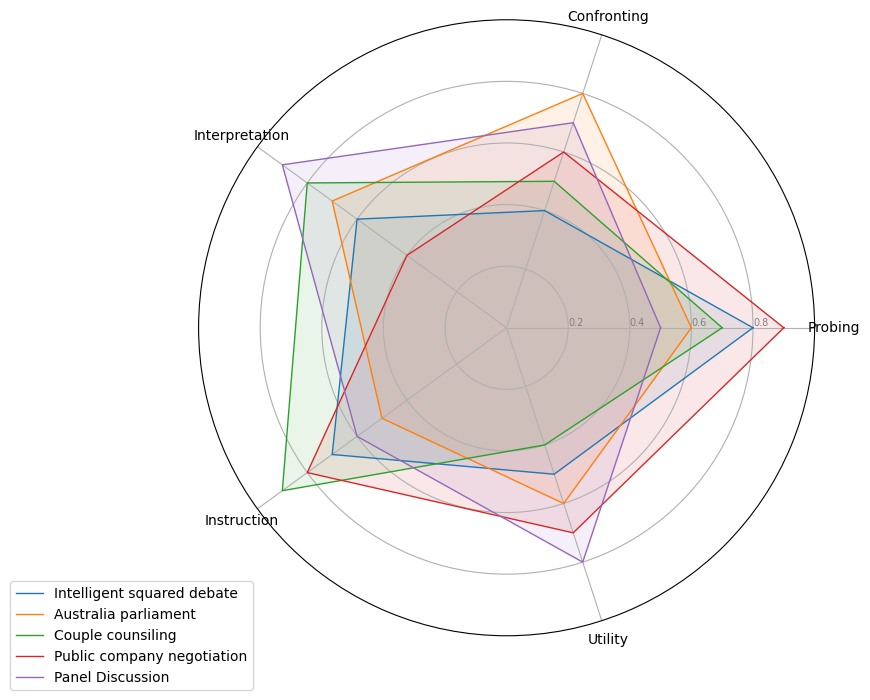

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Example DataFrame
data = {
    'Name': ['Intelligent squared debate', 'Australia parliament', 'Couple counsiling', 'Public company negotiation', 'Panel Discussion'],
    'Probing': [0.8, 0.6, 0.7, 0.9, 0.5],
    'Confronting': [0.4, 0.8, 0.5, 0.6, 0.7],
    'Interpretation': [0.6, 0.7, 0.8, 0.4, 0.9],
    'Instruction': [0.7, 0.5, 0.9, 0.8, 0.6],
    'Utility': [0.5, 0.6, 0.4, 0.7, 0.8]
}

df = pd.DataFrame(data)

# Number of variables we're plotting
categories = list(df.columns[1:])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw y-labels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)

# Plot data
for i in range(len(df)):
    values = df.loc[i].drop('Name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df['Name'][i])
    ax.fill(angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Save the plot as a PDF file
# plt.savefig('spider_plot.pdf', format='pdf')

# Show the plot
plt.show()


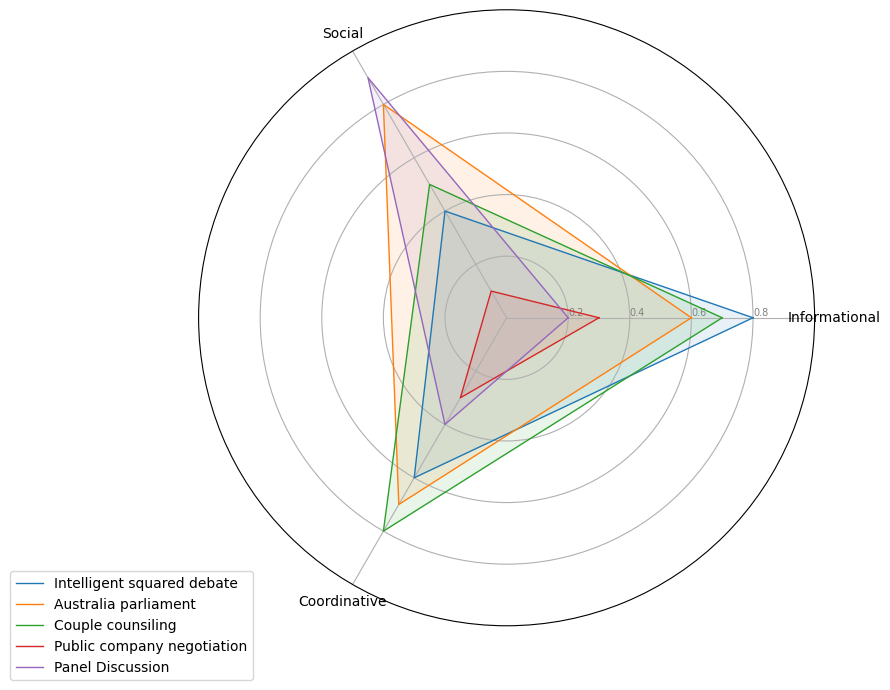

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Example DataFrame
data = {
    'Name': ['Intelligent squared debate', 'Australia parliament', 'Couple counsiling', 'Public company negotiation', 'Panel Discussion'],
    'Informational': [0.8, 0.6, 0.7, 0.3, 0.2],
    'Social': [0.4, 0.8, 0.5, 0.1, 0.9],
    'Coordinative': [0.6, 0.7, 0.8, 0.3, 0.4]
}

df = pd.DataFrame(data)

# Number of variables we're plotting
categories = list(df.columns[1:])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw y-labels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
plt.ylim(0, 1)

# Plot data
for i in range(len(df)):
    values = df.loc[i].drop('Name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=df['Name'][i])
    ax.fill(angles, values, alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Save the plot as a PDF file
# plt.savefig('spider_plot.pdf', format='pdf')

# Show the plot
plt.show()


In [259]:
df = pd.read_excel("mod_sents.xlsx", index_col=0)

In [262]:
df.columns

Index(['text', 'prob', 'conf', 'inst', 'inte', 'supp', 'util', 'im', 'cm',
       'sm'],
      dtype='object')

In [299]:
fdf = df[(df['util'] == True) & (df['im'] == True)]

In [ ]:
for i, r in fdf.iterrows():
    print("------------------------------------------------------------")
    print(r.text)

In [308]:
insq_vp = load_json_data("insq_vote_pairs.json")
rtrp_vp = load_json_data("rtrp_vote_pairs.json")

In [346]:
pairs = insq_vp["da"]

In [351]:
unique_labels = sorted(set([label for pair in pairs for label in pair]))

# Step 2: Initialize an empty co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(
    np.zeros((len(unique_labels), len(unique_labels)), dtype=int),
    index=unique_labels,
    columns=unique_labels
)

# Step 3: Fill the matrix based on co-occurrence counts
for label1, label2 in pairs:
    co_occurrence_matrix.at[label1, label2] += 1
    co_occurrence_matrix.at[label2, label1] += 1  # Since co-occurrence is typically symmetric

# Display the co-occurrence matrix
print(co_occurrence_matrix)

      0    1     2     3     4     5
0  5484  648   716   508   960   358
1   648  764   136   244   134    40
2   716  136  3128    90  1578   626
3   508  244    90  2048   834   138
4   960  134  1578   834  7188  1502
5   358   40   626   138  1502  3672


In [348]:
co_occurrence_matrix = co_occurrence_matrix.div(co_occurrence_matrix.sum(), axis=0)

In [349]:
co_occurrence_matrix.columns = ["prob", "conf", "inst", "inte", "supp", "util"]
co_occurrence_matrix.index = ["prob", "conf", "inst", "inte", "supp", "util"]

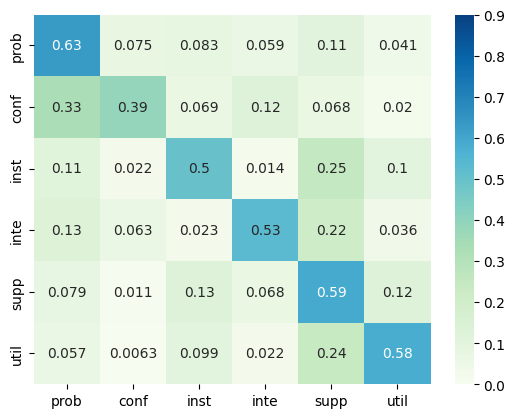

In [350]:
sns.heatmap(co_occurrence_matrix,cbar=True, annot=True, vmin=0.0, vmax=0.9,  cmap="GnBu")
plt.savefig('insq_da_disagree.pdf', format='pdf')

In [355]:
def get_eval_data(corpus):
    with open(f"./data/{corpus}/agg/test.json", mode="r") as f:
        test_data = json.load(f)
    data = {
        "social motive": {
            "gpt":[],
            "human":[],
            "rl_gt":[],
            "rl_vote":[]
        },
        "informational motive": {
            "gpt": [],
            "human": [],
            "rl_gt": [],
            "rl_vote": []
        },
        "coordinative motive": {
            "gpt": [],
            "human": [],
            "rl_gt": [],
            "rl_vote": []
        },
        "dialogue act": {
            "gpt": [],
            "human": [],
            "rl_gt": [],
            "rl_vote": []
        },
        "target speaker":{
            "gpt": [],
            "human": [],
            "rl_gt": [],
            "rl_vote": []
        }
    }

    eval_result = {}

    for num, i in enumerate(test_data):
        try:
            data["informational motive"]["gpt"].append( 1 if "informational motive" in i["answer"]["gpt"]["motives"] else 0)
            data["social motive"]["gpt"].append(1 if "social motive" in i["answer"]["gpt"]["motives"] else 0)
            data["coordinative motive"]["gpt"].append(1 if "coordinative motive" in i["answer"]["gpt"]["motives"] else 0)
            data["dialogue act"]["gpt"].append(i["answer"]["gpt"]["dialogue act"])
            data["target speaker"]["gpt"].append(i["answer"]["gpt"]['target speaker(s)'])

            im = int(i["answer"]["human"]["motives"]["informational motive"]["label"])
            data["informational motive"]["human"].append(im)
            im_votes = [v for k, v in i["answer"]["human"]["motives"]["informational motive"]["vote"].items()]
            data["informational motive"]["rl_vote"].extend(im_votes)
            data["informational motive"]["rl_gt"].extend([im] * len(im_votes))

            cm = int(i["answer"]["human"]["motives"]["coordinative motive"]["label"])
            data["coordinative motive"]["human"].append(cm)
            cm_votes = [v for k, v in i["answer"]["human"]["motives"]["coordinative motive"]["vote"].items()]
            data["coordinative motive"]["rl_vote"].extend(cm_votes)
            data["coordinative motive"]["rl_gt"].extend([cm] * len(cm_votes))

            sm = int(i["answer"]["human"]["motives"]["social motive"]["label"])
            data["social motive"]["human"].append(sm)
            sm_votes = [v for k, v in i["answer"]["human"]["motives"]["social motive"]["vote"].items()]
            data["social motive"]["rl_vote"].extend(sm_votes)
            data["social motive"]["rl_gt"].extend([sm] * len(sm_votes))

            da = int(i["answer"]["human"]["dialogue act"]["label"])
            data["dialogue act"]["human"].append(da)
            da_votes = [v for k, v in i["answer"]["human"]["dialogue act"]["vote"].items()]
            data["dialogue act"]["rl_vote"].extend(da_votes)
            data["dialogue act"]["rl_gt"].extend([da] * len(da_votes))

            ts = int(i["answer"]["human"]["target speaker(s)"]["label"])
            data["target speaker"]["human"].append(ts)
            ts_votes = [v for k, v in i["answer"]["human"]["target speaker(s)"]["vote"].items()]
            data["target speaker"]["rl_vote"].extend(ts_votes)
            data["target speaker"]["rl_gt"].extend([ts] * len(ts_votes))
        except Exception as e:
            print(e)
            print(num)
    
    return data



In [363]:
from sklearn.metrics import confusion_matrix

In [358]:
insq_eval_data = get_eval_data("insq")
rtrp_eval_data = get_eval_data("roundtable")

In [359]:
subsets = [insq_eval_data, rtrp_eval_data]
motives = ["informational motive", "coordinative motive", "social motive"]

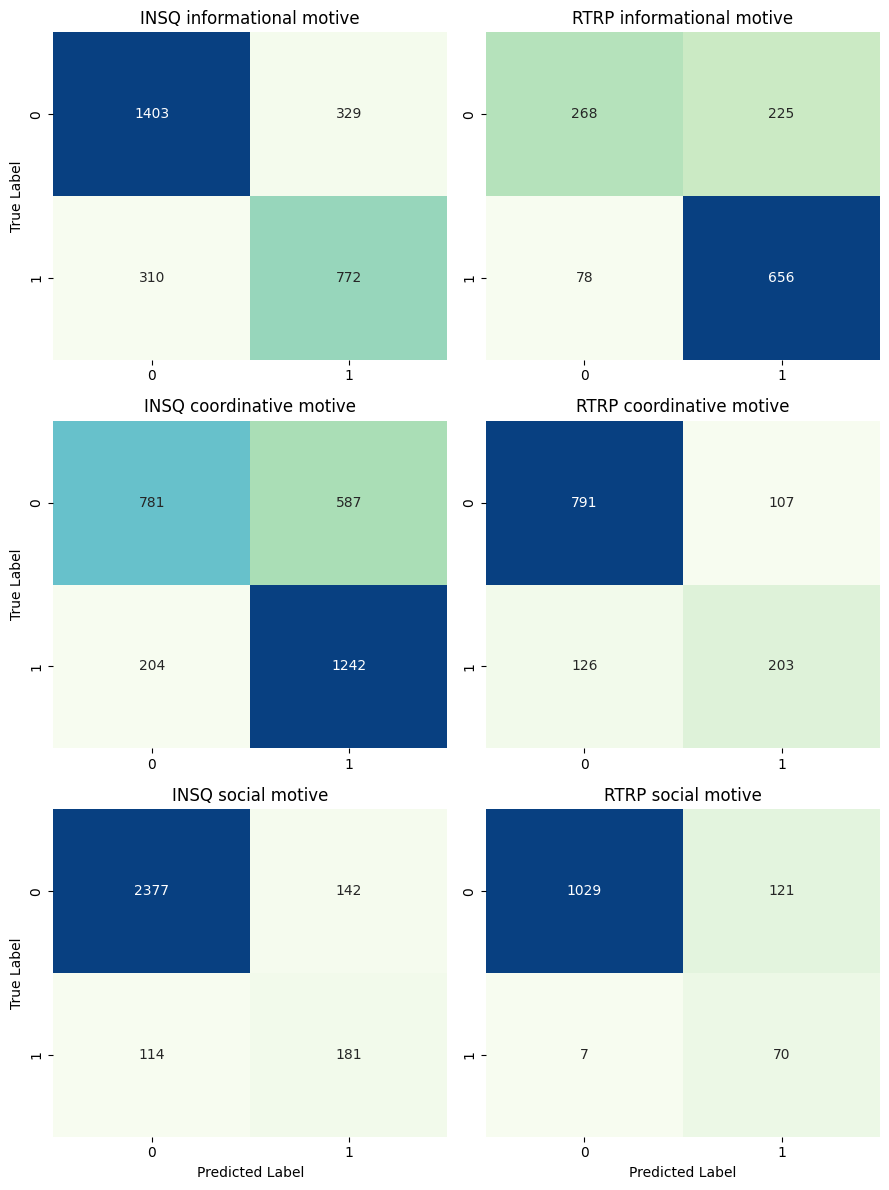

In [377]:

# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(3, 2, figsize=(9, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

axis_index = 0
for m in motives:
    for i, s in enumerate(subsets):
        human = s[m]["human"]
        gpt = s[m]["gpt"]
        matrix = confusion_matrix(human, gpt)
        sns.heatmap(matrix, annot=True, fmt="d", cmap="GnBu", ax=axes[axis_index], cbar=False)
        
        title = ""
        if axis_index % 2 == 0:
            title += "INSQ "
            axes[axis_index].set_ylabel("True Label")
        else:
            title += "RTRP "
        title += m
        axes[axis_index].set_title(title)
        
        if axis_index in [4, 5]:
            axes[axis_index].set_xlabel("Predicted Label")
        axis_index += 1
        
# Plot each confusion matrix heatmap
# for i, cm in enumerate(conf_matrices):
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    # axes[i].set_title(f"Confusion Matrix {i+1}")
    # axes[i].set_xlabel("Predicted Label")
    # axes[i].set_ylabel("True Label")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('motives_confusion_matrix.pdf', format='pdf')
# Display the plots
plt.show()

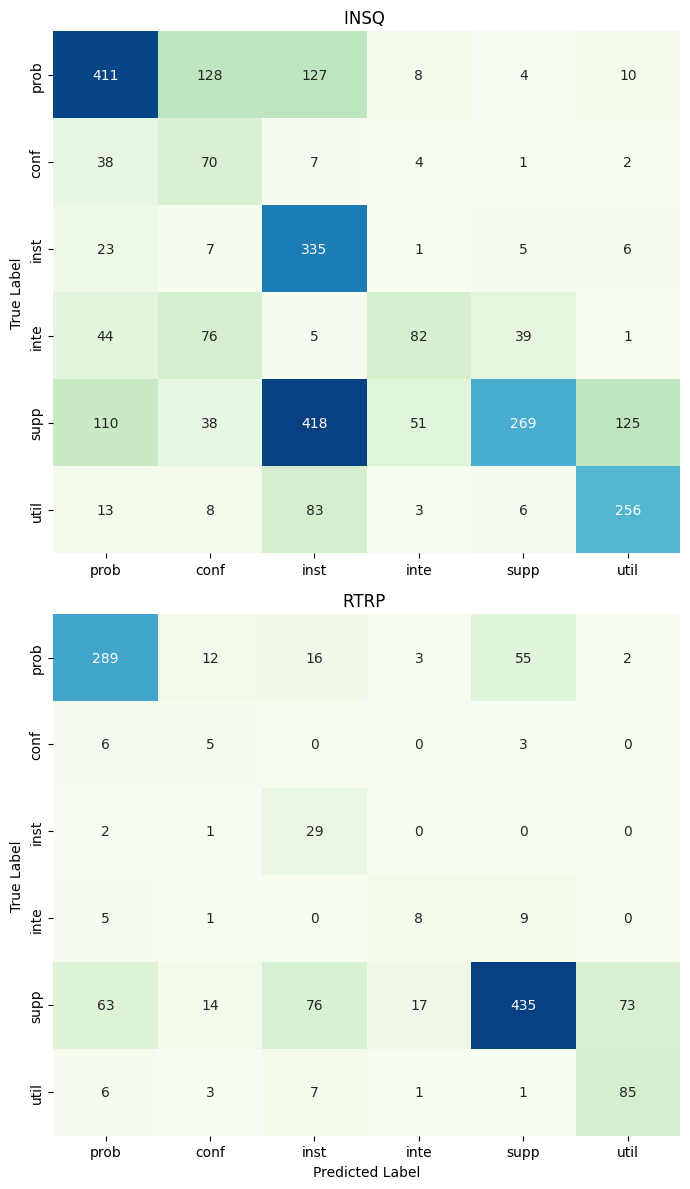

In [386]:
# Set up a 3x2 grid for subplots
fig, axes = plt.subplots(2, 1, figsize=(7, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

axis_index = 0

for i, s in enumerate(subsets):
    human = s["dialogue act"]["human"]
    gpt = s["dialogue act"]["gpt"]
    matrix = confusion_matrix(human, gpt)
    # matrix.columns = ["prob", "conf", "inst", "inte", "supp", "util"]
    # matrix.index = ["prob", "conf", "inst", "inte", "supp", "util"]
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["prob", "conf", "inst", "inte", "supp", "util"],
                yticklabels=["prob", "conf", "inst", "inte", "supp", "util"],cmap="GnBu", ax=axes[axis_index], cbar=False)

    title = ""
    if axis_index % 2 == 0:
        title += "INSQ "
    else:
        title += "RTRP "
    # title += "dialogue act"
    axes[axis_index].set_ylabel("True Label")
    # axes[axis_index].set_yticklabels(["prob", "conf", "inst", "inte", "supp", "util"])
    axes[axis_index].set_title(title)

    if axis_index in [1]:
        axes[axis_index].set_xlabel("Predicted Label")
        # axes[axis_index].set_xticklabels(["prob", "conf", "inst", "inte", "supp", "util"])
    axis_index += 1
    
    
    
        
# Plot each confusion matrix heatmap
# for i, cm in enumerate(conf_matrices):
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    # axes[i].set_title(f"Confusion Matrix {i+1}")
    # axes[i].set_xlabel("Predicted Label")
    # axes[i].set_ylabel("True Label")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('da_confusion_matrix.pdf', format='pdf')
# Display the plots
plt.show()

'informational motive'